# Preliminary flow analysis

- force coefficients
  - loading
  - plotting, smoothing
  - frequency analysis
- velocity probes
  - loading and parsing
  - plotting
  - frequency analysis

In [1]:
from os.path import join
from re import sub
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from scipy.ndimage import gaussian_filter1d
from scipy.signal import welch

plt.rcParams["figure.dpi"] = 180
data_path = "run/surfaceMountedCube/fullCase/postProcessing"

## Force coefficients

References:

- [pandas.read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
- [scipy.ndimage.gaussian_filter1d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter1d.html)
- [scipy.signal.welch()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)

In [2]:
columns = ["t", "cx", "cy", "cz"]
coeffs = read_csv(join(data_path, "forces1/0/coefficient.dat"), sep="\t", comment="#", names=columns)
coeffs.head()

,t,cx,cy,cz
0,0.002,1879.011000,-2.804497,10566.640000
1,0.004,-936.960400,1.460667,-5284.992000
2,0.006,2.128950,-0.234132,-0.828336
3,0.008,1.613873,0.343851,-0.942994
4,0.010,1.608820,0.419745,-0.982987


In [3]:
coeffs.drop(coeffs.index[:2], inplace=True)
coeffs.head()

,t,cx,cy,cz
2,0.006,2.128950,-0.234132,-0.828336
3,0.008,1.613873,0.343851,-0.942994
4,0.010,1.608820,0.419745,-0.982987
5,0.012,1.747422,-0.017026,-0.881171
6,0.014,1.711495,0.376091,-0.929920


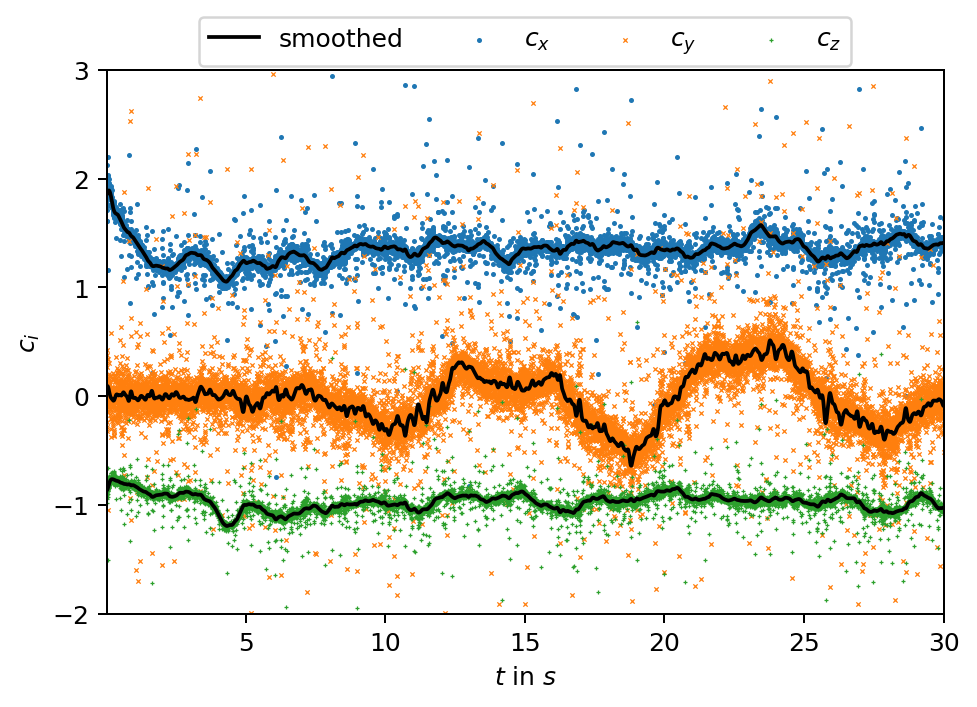

In [4]:
plt.scatter(coeffs.t, coeffs.cx, s=1, marker="o", label=r"$c_x$")
plt.scatter(coeffs.t, coeffs.cy, s=3, marker="x", lw=0.5, label=r"$c_y$")
plt.scatter(coeffs.t, coeffs.cz, s=3, marker="+", lw=0.5, label=r"$c_z$")
plt.plot(coeffs.t, gaussian_filter1d(coeffs.cx, 20), c="k", label="smoothed")
plt.plot(coeffs.t, gaussian_filter1d(coeffs.cy, 20), c="k")
plt.plot(coeffs.t, gaussian_filter1d(coeffs.cz, 20), c="k")

plt.xlim(coeffs.t.min(), coeffs.t.max())
plt.ylim(-2, 3)

plt.xlabel(r"$t$ in $s$")
plt.ylabel(r"$c_i$")
plt.legend(bbox_to_anchor=[0.5, 1.12], ncol=4, loc="upper center")
plt.show()

In [5]:
# time step between samples
dt = coeffs.t.values[1] - coeffs.t.values[0]
# sampling frequency
fs = 1.0 / dt
# skip initial transient
t_start = 10
n_samples = len(coeffs[coeffs.t >= t_start])
dt, fs, n_samples

(0.002, 500.0, 10001)

In [6]:
nwin, npad = 2, 2
cxs = gaussian_filter1d(coeffs[coeffs.t >= t_start].cx.values, 20)
cys = gaussian_filter1d(coeffs[coeffs.t >= t_start].cy.values, 20)
czs = gaussian_filter1d(coeffs[coeffs.t >= t_start].cz.values, 20)
fx, ax = welch(coeffs[coeffs.t >= t_start].cx - coeffs[coeffs.t >= t_start].cx.mean(), fs=fs, nperseg=int(n_samples/nwin), nfft=npad*n_samples)
fxs, axs = welch(cxs - cxs.mean(), fs=fs, nperseg=int(n_samples/nwin), nfft=npad*n_samples)
fys, ays = welch(cys - cys.mean(), fs=fs, nperseg=int(n_samples/nwin), nfft=npad*n_samples)
fzs, azs = welch(czs - czs.mean(), fs=fs, nperseg=int(n_samples/nwin), nfft=npad*n_samples)

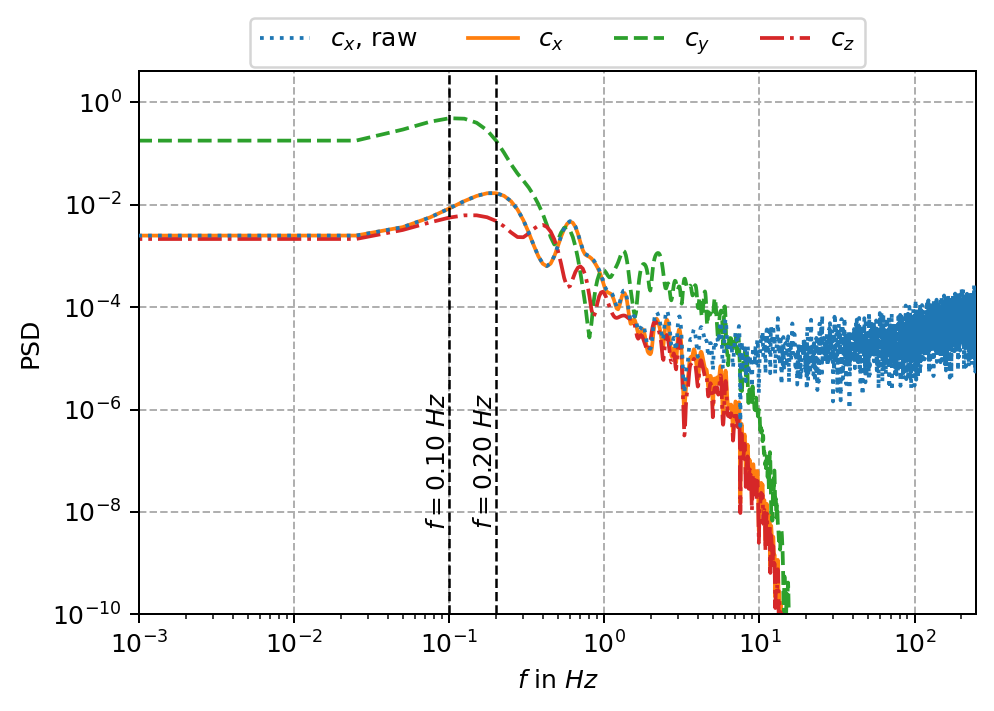

In [7]:
plt.plot(fx, ax, ls=":", label=r"$c_x$, raw", zorder=6)
plt.plot(fxs, axs, ls="-", label=r"$c_x$")
plt.plot(fys, ays, ls="--", label=r"$c_y$")
plt.plot(fzs, azs, ls="-.", label=r"$c_z$")
top_ax_i = axs.argmax()
plt.axvline(fxs[top_ax_i], ls="--", lw=1, c="k")
plt.text(0.85*fxs[top_ax_i], 1e-7, r"$f={:2.2f}\ Hz$".format(fxs[top_ax_i]), rotation=90, va="center", ha="center")
top_ay_i = ays.argmax()
plt.axvline(fys[top_ay_i], ls="--", lw=1, c="k")
plt.text(0.85*fys[top_ay_i], 1e-7, r"$f={:2.2f}\ Hz$".format(fys[top_ay_i]), rotation=90, va="center", ha="center")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 0.5*fs)
plt.ylim(1e-10)
plt.xlabel(r"$f$ in $Hz$")
plt.ylabel("PSD")
plt.legend(bbox_to_anchor=[0.5, 1.12], ncol=4, loc="upper center")
plt.grid(ls="--")
plt.show()

## Velocity probes

In [8]:
with open(join(data_path, "probes1/0/U"), "r") as pfile:
    data = sub("[()]", "", pfile.read())
    names = [f"c{i:d}" for i in range(52)]
    data = read_csv(StringIO(data), header=None, names=names, comment="#", delim_whitespace=True)
data.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c42,c43,c44,c45,c46,c47,c48,c49,c50,c51
0,0.002,1.00297,-0.112667,0.025792,0.688522,-0.008751,0.095766,1.00427,0.108709,0.025905,...,0.138342,1.19495,-0.003494,0.000980,1.22339,-0.001902,0.001346,1.19813,-0.003292,-0.001052
1,0.004,1.00301,-0.112774,0.025812,0.688207,-0.008733,0.095811,1.00433,0.108862,0.025920,...,0.134592,1.19467,-0.003362,0.000966,1.22295,-0.001870,0.001290,1.19785,-0.003346,-0.001068
2,0.006,1.00304,-0.113039,0.025827,0.687957,-0.008862,0.095845,1.00443,0.108922,0.025940,...,0.131280,1.19439,-0.003397,0.000926,1.22251,-0.001960,0.001240,1.19758,-0.003500,-0.001073
3,0.008,1.00307,-0.113003,0.025845,0.687724,-0.008717,0.095866,1.00442,0.109140,0.025950,...,0.128449,1.19414,-0.003200,0.000918,1.22210,-0.001838,0.001195,1.19730,-0.003413,-0.001103
4,0.010,1.00309,-0.112811,0.025864,0.687478,-0.008445,0.095884,1.00435,0.109424,0.025957,...,0.125889,1.19390,-0.002888,0.000922,1.22170,-0.001613,0.001152,1.19702,-0.003210,-0.001148


In [9]:
t = data.c0.values
U = {}
Uraw = data[data.columns[1:]].values
for i, j in enumerate(range(0, 51, 3)):
    U[f"U{i:d}"] = np.linalg.norm(Uraw[:, j:j+3], axis=1)

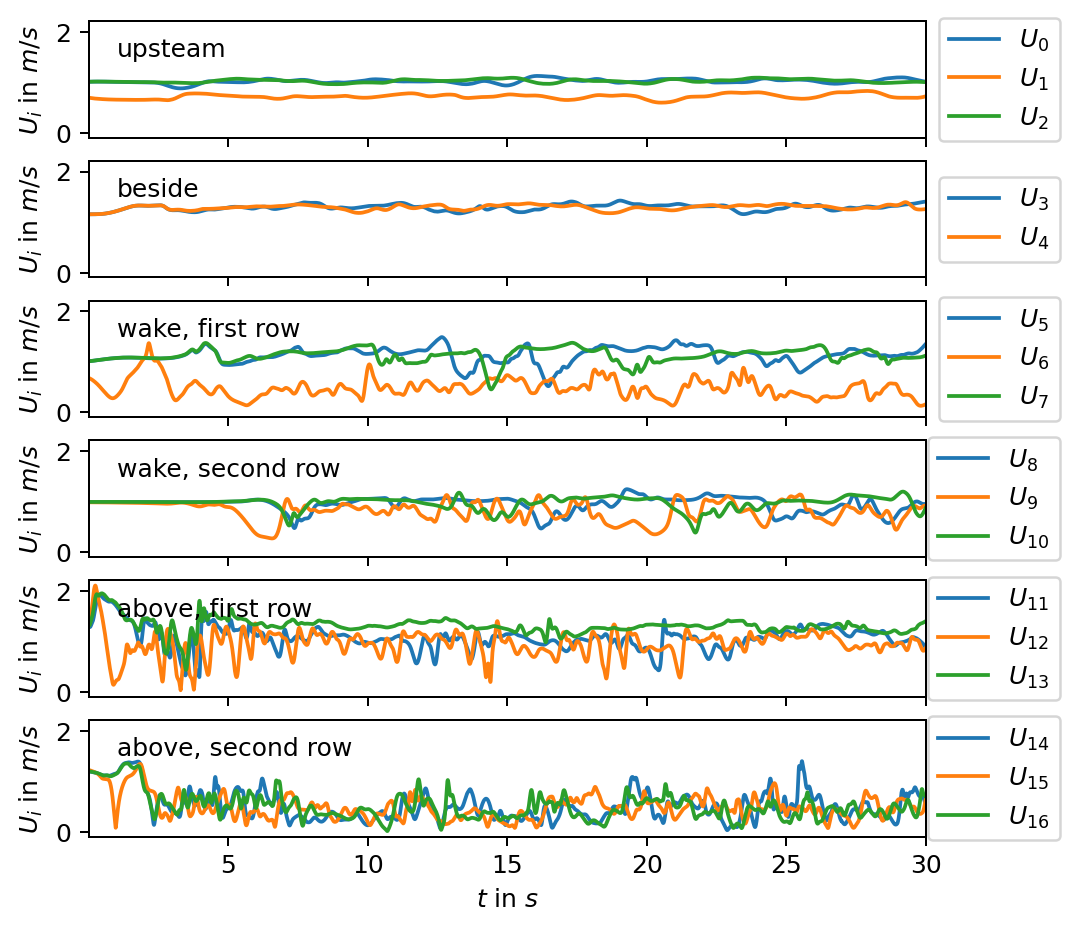

In [10]:
fig, axarr = plt.subplots(6, 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(3):
    axarr[0].plot(t, U[f"U{i:d}"], label=r"$U_{:s}$".format(f"{ {i} }"))
    
for i in range(3, 5):
    axarr[1].plot(t, U[f"U{i:d}"], label=r"$U_{:s}$".format(f"{ {i} }"))
    
for i in range(5, 8):
    axarr[2].plot(t, U[f"U{i:d}"], label=r"$U_{:s}$".format(f"{ {i} }"))
    
for i in range(8, 11):
    axarr[3].plot(t, U[f"U{i:d}"], label=r"$U_{:s}$".format(f"{ {i} }"))
    
for i in range(11, 14):
    axarr[4].plot(t, U[f"U{i:d}"], label=r"$U_{:s}$".format(f"{ {i} }"))
    
for i in range(14, 17):
    axarr[5].plot(t, U[f"U{i:d}"], label=r"$U_{:s}$".format(f"{ {i} }"))

titles = ("upsteam", "beside", "wake, first row", "wake, second row", "above, first row", "above, second row")
for i, ax in enumerate(axarr):
    ax.legend(bbox_to_anchor=[1.175, 0.5], loc="right")
    ax.set_ylabel(r"$U_i$ in $m/s$")
    ax.text(1, 1.5, titles[i])
axarr[-1].set_xlabel(r"$t$ in $s$")
axarr[-1].set_xlim(t.min(), t.max())
plt.show()

In [11]:
U9 = U["U9"][t > t_start]
U9 -= U9.mean()
U12 = U["U12"][t > t_start]
U12 -= U12.mean()
U15 = U["U15"][t > t_start]
U15 -= U15.mean()

In [12]:
f9, a9 = welch(U9, fs=fs, nperseg=int(n_samples/nwin), nfft=npad*n_samples)
f12, a12 = welch(U12, fs=fs, nperseg=int(n_samples/nwin), nfft=npad*n_samples)
f15, a15 = welch(U15, fs=fs, nperseg=int(n_samples/nwin), nfft=npad*n_samples)

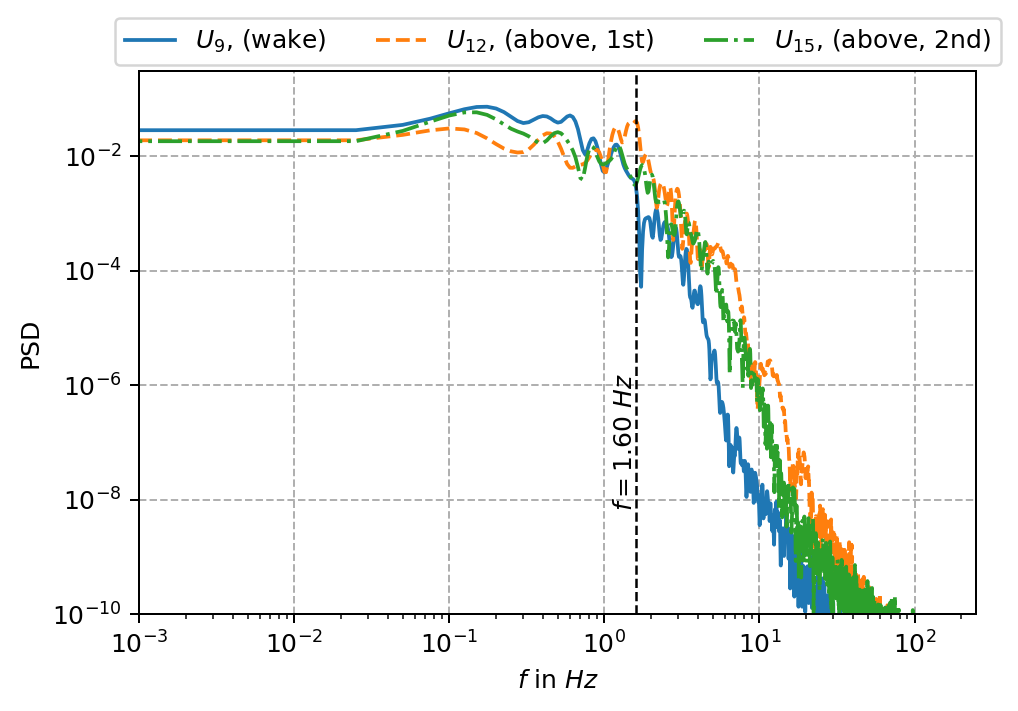

In [13]:
plt.plot(f9, a9, ls="-", label=r"$U_9$, (wake)")
plt.plot(f12, a12, ls="--", label=r"$U_{12}$, (above, 1st)")
plt.plot(f15, a15, ls="-.", label=r"$U_{15}$, (above, 2nd)")
top12_i = a12.argmax()
plt.axvline(f12[top12_i], ls="--", lw=1, c="k")
plt.text(0.85*f12[top12_i], 1e-7, r"$f={:2.2f}\ Hz$".format(f12[top12_i]), rotation=90, va="center", ha="center")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 0.5*fs)
plt.ylim(1e-10)
plt.xlabel(r"$f$ in $Hz$")
plt.ylabel("PSD")
plt.legend(bbox_to_anchor=[0.5, 1.12], ncol=4, loc="upper center")
plt.grid(ls="--")
plt.show()